# Plot the figure of (HR) ocean model description 
- wind stress vector
- time-mean surface elevation
- instant PV in Z1
- instant current speed in Z1

In [2]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
campdir = getenv('CAMP');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));
% 
grid_dir = [workdir '/MOM6_exp/swm_spunup/'];  
[grid, ~, ~] = read_grid_MOM([grid_dir '']); 

## read wind stress

In [3]:
fnm = [workdir '/MOM6_exp/swm_spunup/static_fields.nc'];
ds = ncstruct(fnm);
[taux, tauy] = deal(ds.taux, ds.tauy); % [N m-2]
[taux_p, tauy_p] = uv2p_CG(taux, tauy);
% curl of wind stress [N m-3]
curl_wind = calc_curl_CG(taux,tauy,grid.dxBu,grid.dyBu);
curl_wind_p = curl_wind(1:end-1, 1:end-1);

## read layer thickness

In [4]:
yr_s = 21;
[day_s, day_e, dt] = deal(1, 365*2, 1); 
t_al = day_s:dt:day_e;
nt_al = length(t_al);
h_dir = [campdir '/mom_ptemp/sol_h/'];

h_tm = 0;
for it = 1:nt_al
    [yrstr, dystr, hrstr] = get_timestr(t_al(it), yr_s);
    %---- read
    h_fnm = [h_dir 'h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
    h = ncread(h_fnm,'h');
    h_tm = h_tm + h;
end

h_tm = h_tm/nt_al;
h_tm_sumz = sum(h_tm,3) - 4000; 

## read instant PV and speed

In [5]:
uv_dir = [campdir '/mom_ptemp/sol_prog/'];
t_al_uv = 120;
% read
[yrstr, dystr, hrstr] = get_timestr(t_al_uv, yr_s);
h_fnm = [h_dir 'h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
uv_fnm = [uv_dir 'prog__' yrstr '_' dystr '_' hrstr '.nc'];
h = ncread(h_fnm,'h');
ds_uv = ncstruct(uv_fnm);
% 
[hu, hv] = p2uv_CG(h(:,:,1), h(:,:,1));
[u, v] = deal(ds_uv.u(:,:,1), ds_uv.v(:,:,1));
[up, vp] = uv2p_CG(u, v);
% ----
RV = calc_curl_CG(u,v,grid.dxBu, grid.dyBu);
% f = f0 + beta*y [s-1]
f0 = 4.4e-5;  
beta = 2e-11;
f = f0 + beta * grid.geolatb*1e3; 
% PV [m-1 s-1]
hq = zeros(size(grid.geolatb));
hq(2:end-1,2:end-1) = (hu(2:end-1, 1:end-1) + hu(2:end-1, 2:end) + hv(1:end-1, 2:end-1) + hv(2:end, 2:end-1)) / 4;
PV = (RV + f) ./ hq;
PV_p = PV(1:end-1,1:end-1);
% 
spd = sqrt(up.^2 + vp.^2);

In [6]:
% -- save data
savefnm = [homedir '/work_MOM/data_for_figure/data_fig1.mat'];
save(savefnm,'curl_wind_p','taux_p','tauy_p','h_tm_sumz','PV_p','spd','h_fnm','uv_fnm','t_al');

## plot four fields in one figure

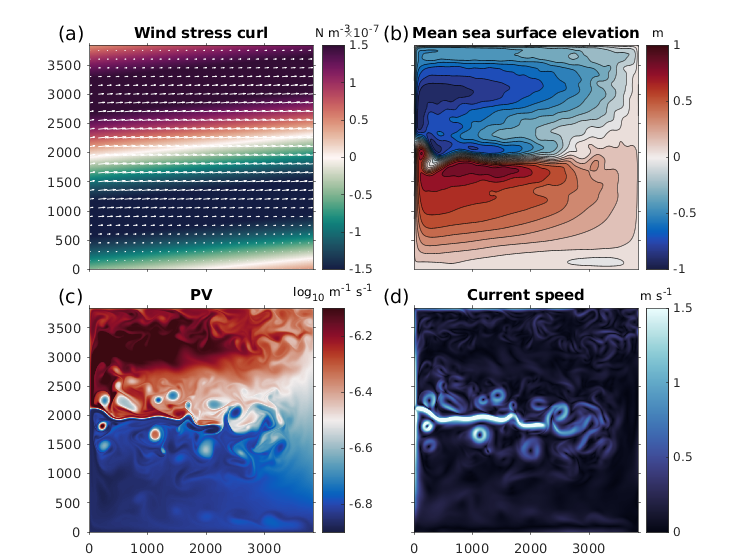

In [7]:
% clear 
% workdir = getenv('WORK');
% homedir = getenv('HOME');
% savefnm = [homedir '/work_MOM/data_for_figure/data_fig1.mat'];
% load(savefnm);
% grid_dir = [workdir '/MOM6_exp/swm_spunup/'];  
% [grid, ~, ~] = read_grid_MOM([grid_dir '']); 

% --- plot
[x, y] = deal(grid.lonh, grid.lath);
plt_fields = {curl_wind_p, h_tm_sumz, log10(PV_p), spd};
ncel = numel(plt_fields);
clim_al = {[-1 1]*1.5e-7, [-1 1], [-6.9 -6.1], [0 1.5]}; 
cmstr_al = {'curl', 'balance', 'balance', 'ice'};
title_al = {'Wind stress curl', 'Mean sea surface elevation', 'PV', 'Current speed'};
cbstr_al = {'N m^{-3}', 'm', 'log_{10} m^{-1} s^{-1}', 'm s^{-1}'};

% figure
font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);
[ha, ~] = tight_subplot(2,2,[.07 .02],[.05 .08],[.10 .05]);

for icel = 1:4
    axes(ha(icel));
    f_do = plt_fields{icel};
    if icel == 2
        contourf(x,y,f_do',18);
    else
        imagescn(x, y, f_do');
        if icel == 1
            hold on
            dx_plt = 40; dy_plt = 40;
            [ii,jj] = deal(1:dx_plt:grid.nih, 1:dy_plt:grid.njh);
            quiver(grid.geolon(ii,jj),grid.geolat(ii,jj),taux_p(ii,jj),tauy_p(ii,jj),'LineWidth',.7,'Color','w'); 
        end
    end
    
    if icel == 1; set(gca,'xticklabel',''); end
    if icel == 2; set(gca,'xticklabel','','yticklabel',''); end
    if icel == 4; set(gca,'yticklabel',''); end
    
    axis square
    set(gca,'tickdir','out');
    title(title_al{icel}, 'HorizontAlalignment', 'center');
    caxis(clim_al{icel});
    cmocean(cmstr_al{icel})
    cb = colorbar;
    cb.Title.String = cbstr_al{icel};
end
hb = subplotlabel(gcf,'a','location','northwestoutside','offset',[-0.14 0],'Prefix','(','Postfix',')');
set(gcf,'PaperPositionMode','auto'); 
% ---
fignm = [homedir '/work_MOM/figures/fig1'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')